In [2]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm, gaussian_kde
import warnings

warnings.filterwarnings("ignore")


# Trouble-shooting: adding C in data sampling and enable C in model fitting for y

## Include c in prediction

In [7]:
s, x,z,y= generate_data_longitudinl(n=8000,T=3,C_coeff=0.01)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)


2.111009641000812


In [11]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=3, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True)

model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 4.1953,	loss_y 2.6343, 2.6573, 0.0460,	loss_eta 1.5611, 1.6106, 0.0991
Epoch 1000: loss 2.2292,	loss_y 1.0978, 2.1899, 2.1841,	loss_eta 1.1314, 2.2369, 2.2110
Epoch 2000: loss 2.2186,	loss_y 1.0863, 2.1744, 2.1761,	loss_eta 1.1323, 2.2554, 2.2462
Epoch 3000: loss 2.2124,	loss_y 1.0922, 2.1740, 2.1635,	loss_eta 1.1202, 2.2387, 2.2369
Epoch 4000: loss 2.2159,	loss_y 1.0904, 2.1813, 2.1818,	loss_eta 1.1254, 2.2409, 2.2309


In [12]:
y_margin_sample=model.sample_causal_margin(s=torch.tensor([[0]],dtype=torch.float32), 
                                            x = torch.tensor([[1,1,1]],dtype=torch.int32),
                                            sample_size=1000)


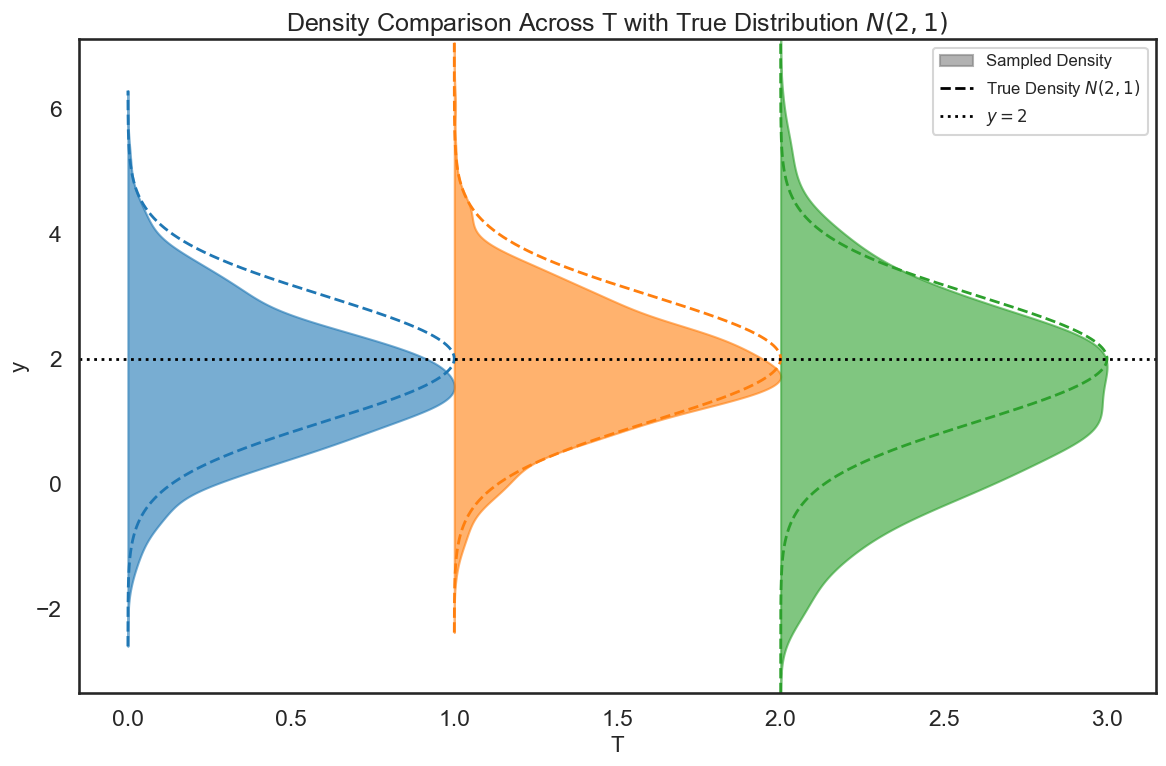

In [13]:
# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(3)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

In [20]:
s, x,z,y= generate_data_longitudinl(n=8000,T=3,C_coeff=1)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=3, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True)

model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=1000)

2.2860466379905504
Epoch 1: loss 4.7386,	loss_y 3.1922, 3.2188, 0.0532,	loss_eta 1.5464, 1.6101, 0.1275
Epoch 1000: loss 2.2098,	loss_y 1.0975, 2.1822, 2.1694,	loss_eta 1.1123, 2.2358, 2.2470
Epoch 2000: loss 2.1962,	loss_y 1.0835, 2.1706, 2.1741,	loss_eta 1.1127, 2.2328, 2.2403
Epoch 3000: loss 2.2099,	loss_y 1.0858, 2.1689, 2.1662,	loss_eta 1.1242, 2.2418, 2.2352
Epoch 4000: loss 2.2030,	loss_y 1.0775, 2.1752, 2.1952,	loss_eta 1.1254, 2.2478, 2.2447


In [21]:
y_margin_sample=model.sample_causal_margin(s=torch.tensor([[0]],dtype=torch.float32), 
                                            x = torch.tensor([[1,1,1]],dtype=torch.int32),
                                            sample_size=1000)


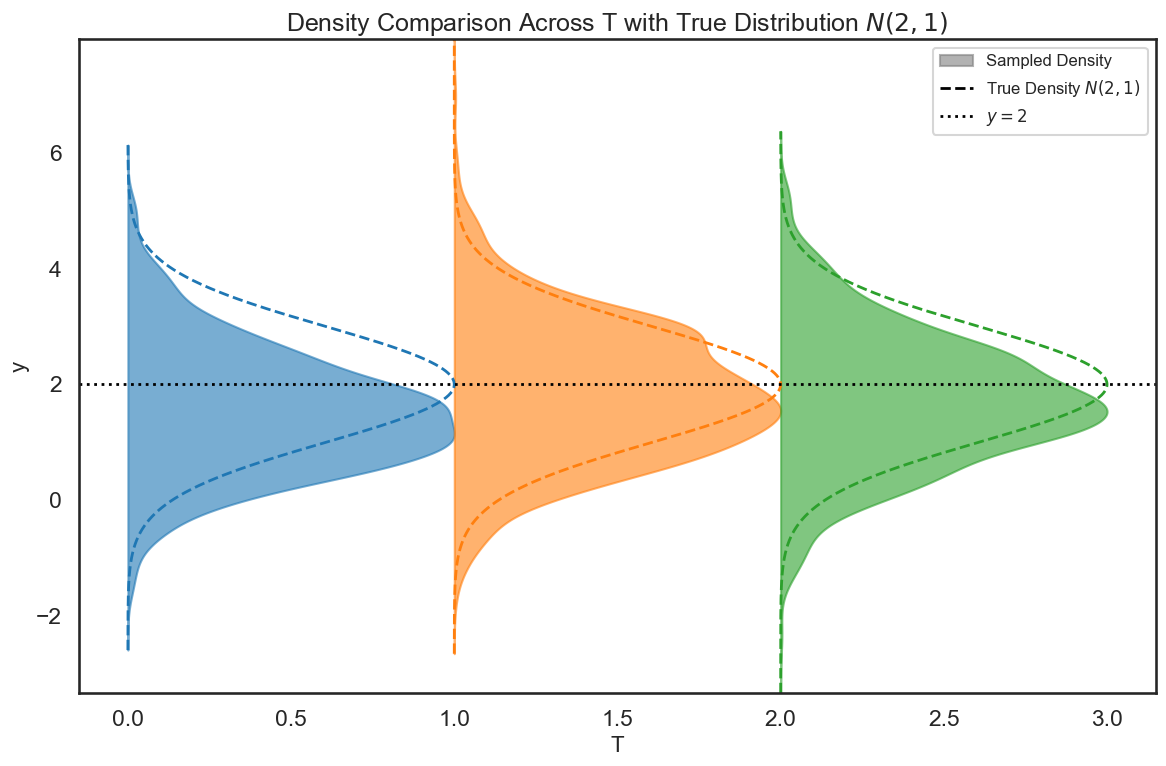

In [22]:
# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(3)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

## Exclude c in prediction

In [33]:
s, x,z,y= generate_data_longitudinl(n=8000,T=3,C_coeff=1)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=3, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=False)

model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=1000)

2.2860466379905504
Epoch 1: loss 4.7784,	loss_y 3.2361, 3.2670, 0.0618,	loss_eta 1.5423, 1.6057, 0.1269
Epoch 1000: loss 2.2130,	loss_y 1.0739, 2.1960, 2.2441,	loss_eta 1.1390, 2.2665, 2.2549
Epoch 2000: loss 2.2061,	loss_y 1.0793, 2.1698, 2.1810,	loss_eta 1.1268, 2.2377, 2.2218
Epoch 3000: loss 2.2210,	loss_y 1.0963, 2.1845, 2.1764,	loss_eta 1.1247, 2.2348, 2.2201
Epoch 4000: loss 2.2070,	loss_y 1.0717, 2.1636, 2.1839,	loss_eta 1.1354, 2.2371, 2.2035


In [34]:
y_margin_sample=model.sample_causal_margin(s=torch.tensor([[0]],dtype=torch.float32), 
                                            x = torch.tensor([[1,1,1]],dtype=torch.int32),
                                            sample_size=1000)
                                            

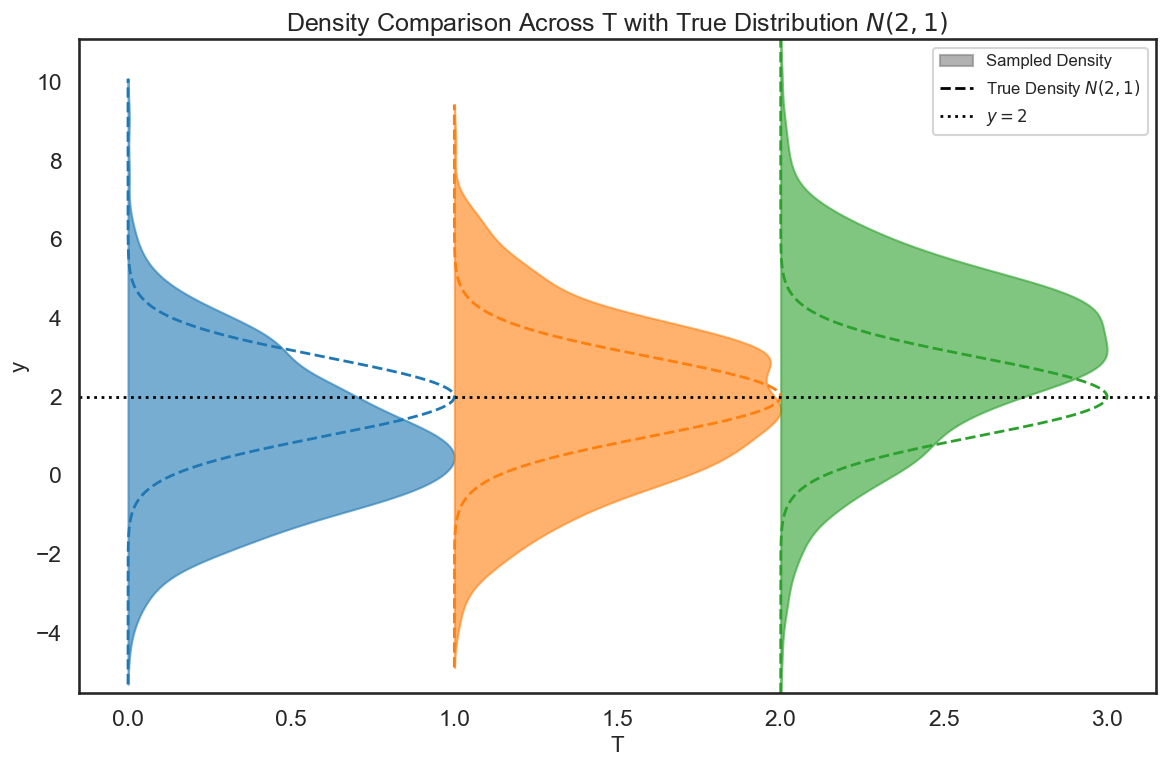

In [35]:
# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(3)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

In [36]:
s, x,z,y= generate_data_longitudinl(n=8000,T=3,C_coeff=0.001)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=3, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=False)

model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=4000, lr=1e-4, print_every_iter=1000)

2.1094183955736323
Epoch 1: loss 4.1325,	loss_y 2.5937, 2.6408, 0.0941,	loss_eta 1.5387, 1.6057, 0.1340
Epoch 1000: loss 2.2215,	loss_y 1.0827, 2.1843, 2.2033,	loss_eta 1.1388, 2.2589, 2.2403
Epoch 2000: loss 2.2214,	loss_y 1.0911, 2.1695, 2.1567,	loss_eta 1.1302, 2.2521, 2.2437
Epoch 3000: loss 2.2053,	loss_y 1.0854, 2.1706, 2.1704,	loss_eta 1.1199, 2.2402, 2.2407
Epoch 4000: loss 2.1968,	loss_y 1.0837, 2.1831, 2.1988,	loss_eta 1.1130, 2.2466, 2.2672


In [37]:
y_margin_sample=model.sample_causal_margin(s=torch.tensor([[0]],dtype=torch.float32), 
                                            x = torch.tensor([[1,1,1]],dtype=torch.int32),
                                            sample_size=1000)

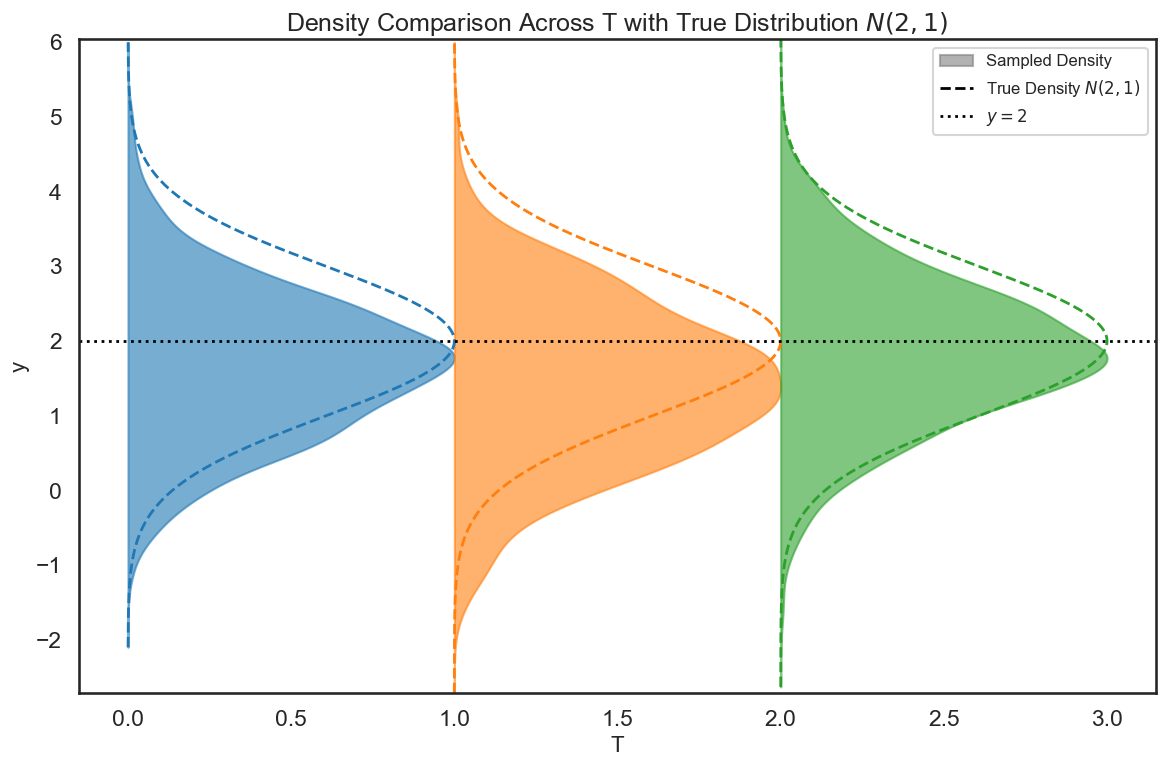

In [38]:
# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(3)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

## Sanity check on fengression of last step

In [ ]:
s, x,z,y= generate_data_longitudinl(n=6000,T=5,C_coeff=0)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x[:,3:4], dtype=torch.float32)
y_tr = torch.tensor(y[:,3:4], dtype=torch.float32)
z_tr = torch.concat([s_tr,torch.tensor(z, dtype=torch.float32)],dim=1)

model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=3, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, 
                        device=device, x_binary = True, s_in_predict=True)

model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=10000, lr=1e-4, print_every_iter=1000)

2.067551403528454


In [18]:
fr_model = Frengression(
        x_dim=x_tr.shape[1], y_dim=y_tr.shape[1], z_dim=z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=100,
        device=device, x_binary=True
    )
fr_model.train_y(x=x_tr, z=z_tr, y=y_tr, num_iters=6000, lr=1e-4, print_every_iter=400)


Epoch 1: loss 2.0523,	loss_y 1.2997, 1.3125, 0.0256,	loss_eta 0.7526, 0.7957, 0.0863
Epoch 400: loss 1.1695,	loss_y 0.5977, 1.4295, 1.6636,	loss_eta 0.5719, 0.9607, 0.7776
Epoch 800: loss 1.1965,	loss_y 0.5832, 1.0392, 0.9120,	loss_eta 0.6133, 1.1155, 1.0044
Epoch 1200: loss 1.2804,	loss_y 0.6992, 1.5222, 1.6460,	loss_eta 0.5812, 1.0639, 0.9653
Epoch 1600: loss 1.1974,	loss_y 0.6208, 1.3582, 1.4749,	loss_eta 0.5767, 1.1576, 1.1619
Epoch 2000: loss 1.1817,	loss_y 0.5633, 1.1832, 1.2399,	loss_eta 0.6184, 0.9510, 0.6651
Epoch 2400: loss 1.2284,	loss_y 0.6478, 1.3899, 1.4843,	loss_eta 0.5806, 0.9632, 0.7652
Epoch 2800: loss 1.1715,	loss_y 0.5918, 1.2296, 1.2757,	loss_eta 0.5798, 1.3245, 1.4895
Epoch 3200: loss 1.1745,	loss_y 0.5961, 1.1856, 1.1790,	loss_eta 0.5784, 1.3663, 1.5758
Epoch 3600: loss 1.1839,	loss_y 0.5833, 1.1101, 1.0537,	loss_eta 0.6007, 0.9686, 0.7359
Epoch 4000: loss 1.1537,	loss_y 0.5716, 1.2994, 1.4556,	loss_eta 0.5820, 1.0400, 0.9159
Epoch 4400: loss 1.1607,	loss_y 0.580

In [28]:
y_margin_sample = fr_model.sample_causal_margin(x=torch.tensor([1]),sample_size=10)

In [29]:
y_margin_sample 

tensor([[[ 2.6269, -0.4488,  2.7238,  2.0901,  1.1432,  1.6943,  0.8591,
           1.3925,  3.0051,  0.2535]]])

(array([  3.,  11.,  41., 233., 314., 207., 124.,  45.,  16.,   6.]),
 array([-0.52903211,  0.0383227 ,  0.60567749,  1.17303228,  1.74038708,
         2.30774188,  2.8750968 ,  3.44245148,  4.00980616,  4.57716131,
         5.14451599]),
 <BarContainer object of 10 artists>)

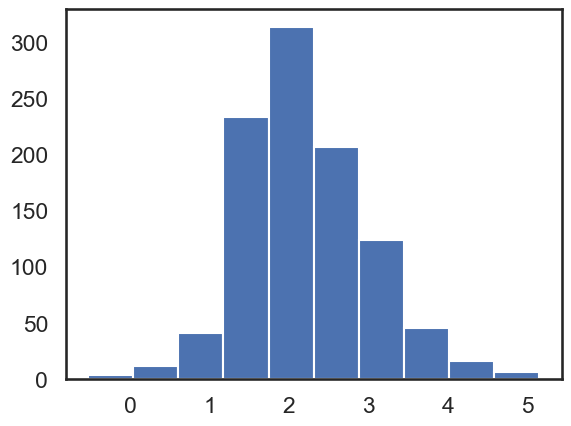

In [33]:
plt.hist(y_margin_sample[0][0])

## Sanity check: incoporate S in predicition inptut

In [78]:
s, x,z,y= generate_data_longitudinl(n=10000,T=3,C_coeff=0.5)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s_tr = torch.tensor(s, dtype=torch.float32)
x_tr = torch.tensor(x, dtype=torch.int32)
y_tr = torch.tensor(y, dtype=torch.float32)
z_tr = torch.tensor(z, dtype=torch.float32)

2.18578881832818


In [79]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=3, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(s=s_tr,x=x_tr,z=z_tr,y=y_tr,num_iters=8000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 4.3222,	loss_y 2.7844, 2.8235, 0.0781,	loss_eta 1.5377, 1.6069, 0.1384
Epoch 1000: loss 2.2323,	loss_y 1.0883, 2.1799, 2.1831,	loss_eta 1.1440, 2.2614, 2.2350
Epoch 2000: loss 2.2076,	loss_y 1.0829, 2.1701, 2.1744,	loss_eta 1.1247, 2.2585, 2.2676
Epoch 3000: loss 2.2074,	loss_y 1.0791, 2.1715, 2.1846,	loss_eta 1.1282, 2.2461, 2.2358
Epoch 4000: loss 2.2202,	loss_y 1.0848, 2.1711, 2.1727,	loss_eta 1.1355, 2.2591, 2.2473
Epoch 5000: loss 2.2140,	loss_y 1.0869, 2.1729, 2.1720,	loss_eta 1.1271, 2.2559, 2.2575
Epoch 6000: loss 2.2093,	loss_y 1.0772, 2.1621, 2.1699,	loss_eta 1.1321, 2.2496, 2.2350
Epoch 7000: loss 2.2038,	loss_y 1.0762, 2.1605, 2.1687,	loss_eta 1.1276, 2.2440, 2.2329
Epoch 8000: loss 2.2083,	loss_y 1.0768, 2.1553, 2.1570,	loss_eta 1.1315, 2.2491, 2.2351


In [73]:
s=torch.tensor([[1]]),

tensor([-0.3895])

In [74]:
y_margin_sample = model.sample_causal_margin(s=torch.tensor([[0]]), x=torch.tensor([[1,1,1]], dtype=torch.int32),sample_size=5000)

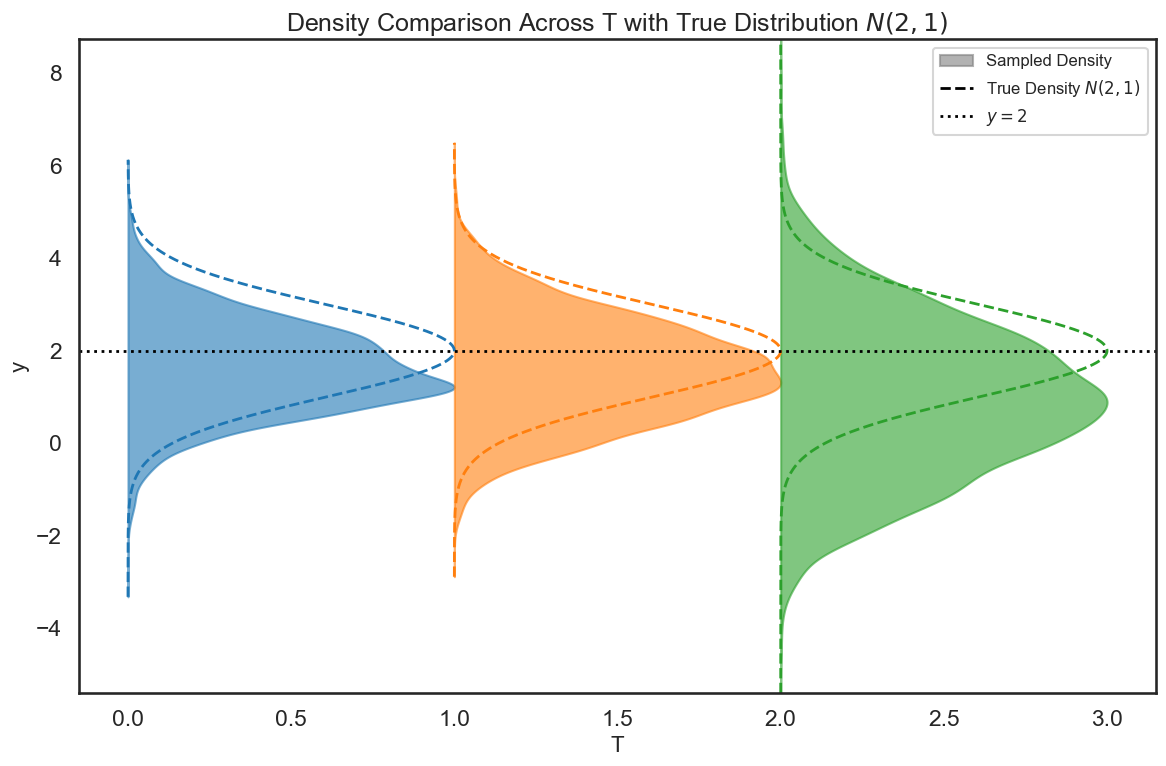

In [75]:


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(3)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


# Experiment: no C included in frengressionseq
The experiment results below were done when C( or s) is not included in the design of Frengressionseq. In particular, C( or s) is not used in y sampling / prediction.

## joint time trajectory

In [2]:
s, x,z,y= generate_data_survivl(n=30000,T=5)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)

2.0909338076738213


In [3]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(x=x,z=z,y=y,num_iters=6000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 5.5437,	loss_y 3.4944, 3.5384, 0.0880,	loss_eta 2.0492, 2.1346, 0.1708
Epoch 1000: loss 2.9736,	loss_y 1.4667, 2.9312, 2.9289,	loss_eta 1.5069, 2.9905, 2.9672
Epoch 2000: loss 2.9709,	loss_y 1.4652, 2.9268, 2.9232,	loss_eta 1.5057, 2.9971, 2.9829
Epoch 3000: loss 2.9684,	loss_y 1.4679, 2.9295, 2.9231,	loss_eta 1.5005, 2.9939, 2.9869
Epoch 4000: loss 2.9674,	loss_y 1.4634, 2.9316, 2.9364,	loss_eta 1.5040, 3.0076, 3.0071
Epoch 5000: loss 2.9677,	loss_y 1.4615, 2.9236, 2.9241,	loss_eta 1.5061, 3.0052, 2.9981
Epoch 6000: loss 2.9666,	loss_y 1.4616, 2.9313, 2.9394,	loss_eta 1.5050, 2.9975, 2.9849


In [4]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1,1,1,1,1]]), sample_size=1000)

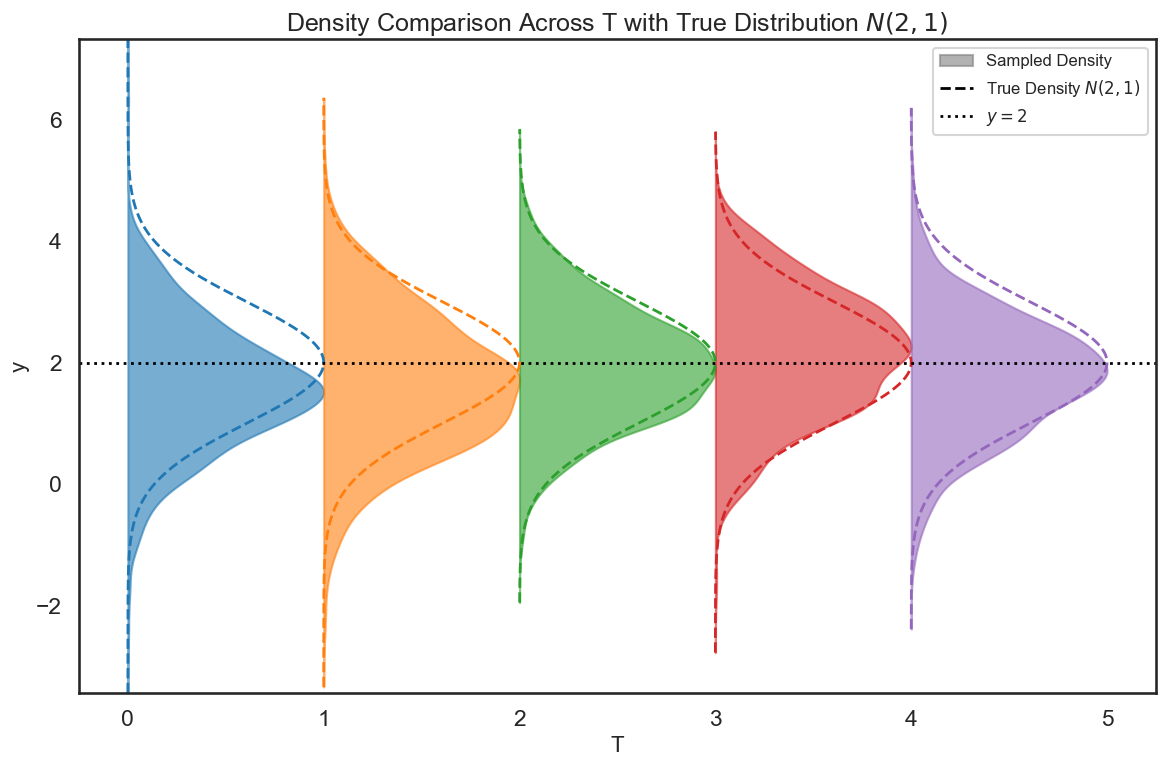

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(5)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


In [7]:
s, x,z,y= generate_data_survivl(n=30000,T=10)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(x=x,z=z,y=y,num_iters=8000, lr=1e-4, print_every_iter=1000)

2.0909338076738213
Epoch 1: loss 8.0583,	loss_y 5.0842, 5.1553, 0.1421,	loss_eta 2.9741, 3.0997, 0.2511
Epoch 1000: loss 4.3088,	loss_y 2.1291, 4.2484, 4.2386,	loss_eta 2.1797, 4.3538, 4.3480
Epoch 2000: loss 4.2984,	loss_y 2.1254, 4.2412, 4.2316,	loss_eta 2.1730, 4.3427, 4.3395
Epoch 3000: loss 4.2965,	loss_y 2.1118, 4.2236, 4.2236,	loss_eta 2.1847, 4.3517, 4.3339
Epoch 4000: loss 4.2854,	loss_y 2.1094, 4.2266, 4.2345,	loss_eta 2.1761, 4.3497, 4.3473
Epoch 5000: loss 4.2905,	loss_y 2.1123, 4.2234, 4.2223,	loss_eta 2.1782, 4.3393, 4.3221
Epoch 6000: loss 4.2896,	loss_y 2.1006, 4.2067, 4.2123,	loss_eta 2.1890, 4.3431, 4.3082
Epoch 7000: loss 4.2689,	loss_y 2.0857, 4.1842, 4.1969,	loss_eta 2.1832, 4.3365, 4.3067
Epoch 8000: loss 4.2655,	loss_y 2.0784, 4.1726, 4.1885,	loss_eta 2.1872, 4.3359, 4.2974


In [ ]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1,1,1,1,1]]), sample_size=1000)

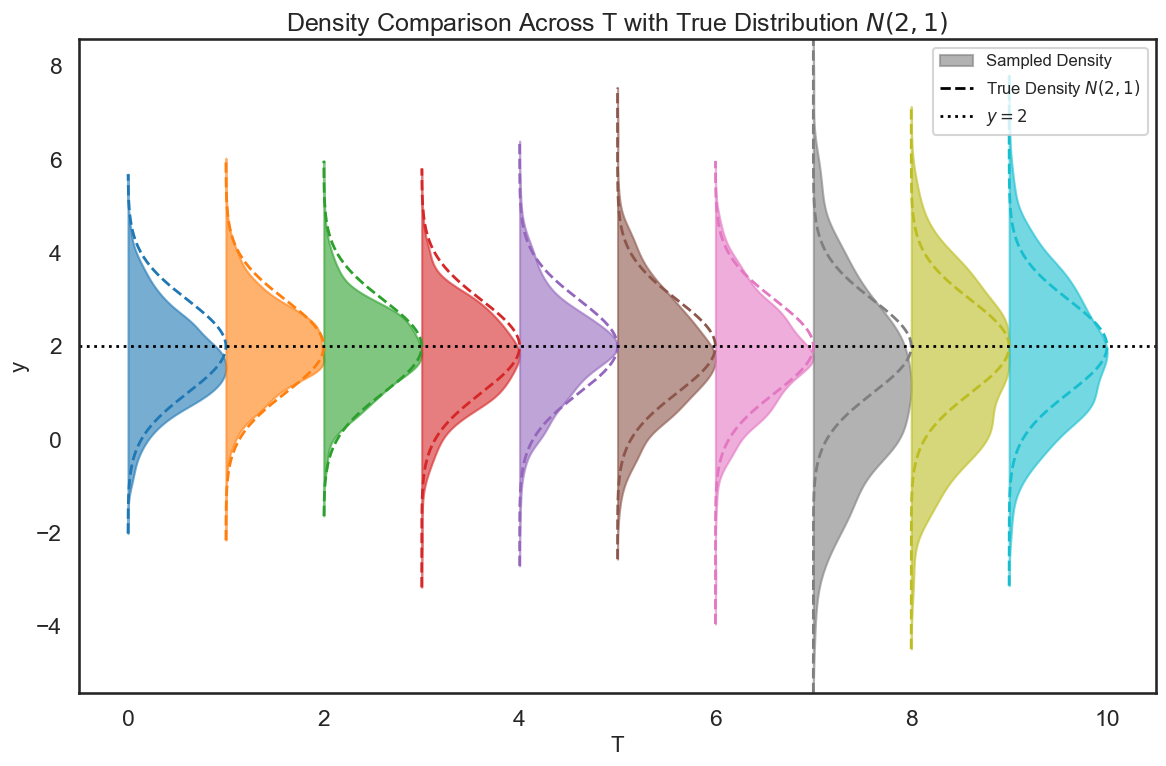

In [24]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1]*10]), sample_size=1000)
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(10)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()
